# CSV Transform Demo

Demonstrates how to use entra to transform real data from CSV files or pandas DataFrames.

This notebook shows:
1. Generate sample data (uniform distribution) and save to CSV
2. Read the CSV and transform towards Gaussian
3. Visualize the transformation
4. Compare entropy before and after

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from entra import DataFrameTransformer, transform_csv

## 1. Generate Sample Data

Create a uniform 2D grid and save it to CSV.

In [2]:
# Generate uniform 2D grid
n_per_dim = 20
x = np.linspace(-10, 10, n_per_dim)
y = np.linspace(-10, 10, n_per_dim)
xx, yy = np.meshgrid(x, y)

df = pd.DataFrame({
    'id': range(len(xx.ravel())),
    'x': xx.ravel(),
    'y': yy.ravel(),
    'label': ['A' if i % 2 == 0 else 'B' for i in range(len(xx.ravel()))]
})

print(f"Generated {len(df)} points")
print(f"Columns: {list(df.columns)}")
df.head()

Generated 400 points
Columns: ['id', 'x', 'y', 'label']


,id,x,y,label
0,0,-10.000000,-10.0,A
1,1,-8.947368,-10.0,B
2,2,-7.894737,-10.0,A
3,3,-6.842105,-10.0,B
4,4,-5.789474,-10.0,A


In [3]:
# Save to CSV
input_csv = '/tmp/sample_vectors.csv'
df.to_csv(input_csv, index=False)
print(f"Saved to: {input_csv}")

Saved to: /tmp/sample_vectors.csv


## 2. Visualize Original Data

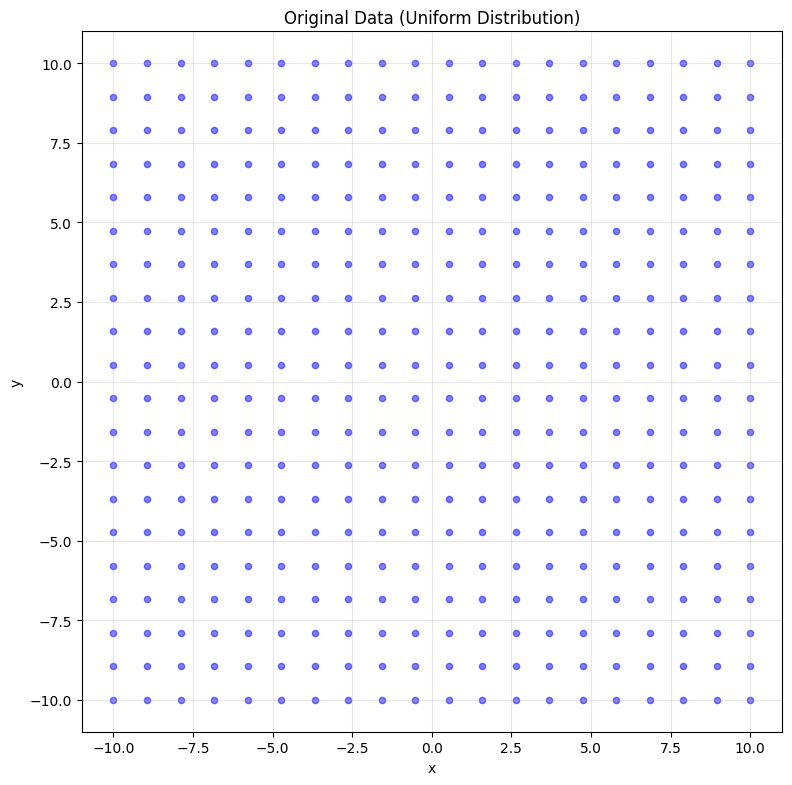

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(df['x'], df['y'], c='blue', alpha=0.5, s=20)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Original Data (Uniform Distribution)')
ax.set_aspect('equal')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Transform Using DataFrame API

Use `DataFrameTransformer` to fit and transform the data.

In [5]:
# Create transformer with optimal parameters
transformer = DataFrameTransformer(
    sigma=5.0,           # RBF width (5 * delta_x where delta_x = 1)
    center_stride=1,     # Use all points as centers
    max_iterations=100,
    verbose=True
)

# Fit and transform
df_transformed = transformer.fit_transform(df, columns=['x', 'y'])

Fitting transformer: 400 points, 2 dimensions
  sigma = 5.0
  center_stride = 1
  L = 400 basis centers

  Note: H(Gaussian) is the entropy IF the distribution were Gaussian with
  the current covariance. It decreases because we start from uniform.

   Iter     Determinant   H(Gaussian)      Lambda
  --------------------------------------------------
      0    1.364153e+03        6.4470    1.00e+00
      1    1.364041e+03        6.4470    1.00e-01
      2    1.362918e+03        6.4466    1.00e-02
      3    1.351866e+03        6.4425    1.00e-03
      4    1.257528e+03        6.4063    1.00e-04
      5    1.209587e+03        6.3869    1.00e-05
      7    1.181908e+03        6.3753    1.00e-05
      9    1.163433e+03        6.3674    1.00e-05
     11    1.150380e+03        6.3618    1.00e-05
     13    1.144294e+03        6.3591    1.00e-05
     16    1.101070e+03        6.3399    1.00e-04
     18    1.075591e+03        6.3282    1.00e-04
     20    1.059635e+03        6.3207    1.00e-

## 4. Visualize Transformed Data

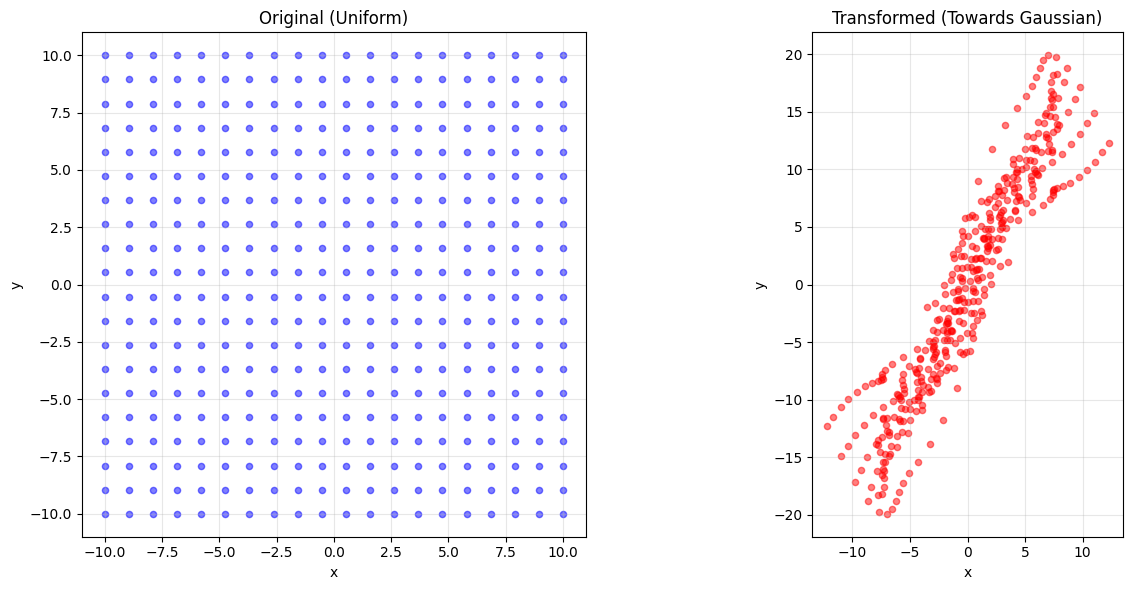

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Original
axes[0].scatter(df['x'], df['y'], c='blue', alpha=0.5, s=20)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Original (Uniform)')
axes[0].set_aspect('equal')
axes[0].grid(True, alpha=0.3)

# Transformed
axes[1].scatter(df_transformed['x'], df_transformed['y'], c='red', alpha=0.5, s=20)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Transformed (Towards Gaussian)')
axes[1].set_aspect('equal')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Compare Entropy

In [7]:
entropy = transformer.get_entropy_comparison(df, df_transformed)

print("Entropy Comparison")
print("=" * 50)
print(f"Original k-NN entropy:    {entropy['original']['knn_entropy']:.6f}")
print(f"Transformed k-NN entropy: {entropy['transformed']['knn_entropy']:.6f}")
print(f"Transformed Gaussian H:   {entropy['transformed']['gaussian_entropy']:.6f}")
print()
print(f"Original determinant:     {entropy['original']['determinant']:.6e}")
print(f"Transformed determinant:  {entropy['transformed']['determinant']:.6e}")
print(f"Determinant reduction:    {entropy['original']['determinant'] / entropy['transformed']['determinant']:.2f}x")

Entropy Comparison
Original k-NN entropy:    7.707972
Transformed k-NN entropy: 6.889671
Transformed Gaussian H:   5.717965

Original determinant:     1.364153e+03
Transformed determinant:  3.174043e+02
Determinant reduction:    4.30x


## 6. Marginal Distributions

Compare 1D histograms before and after transformation.

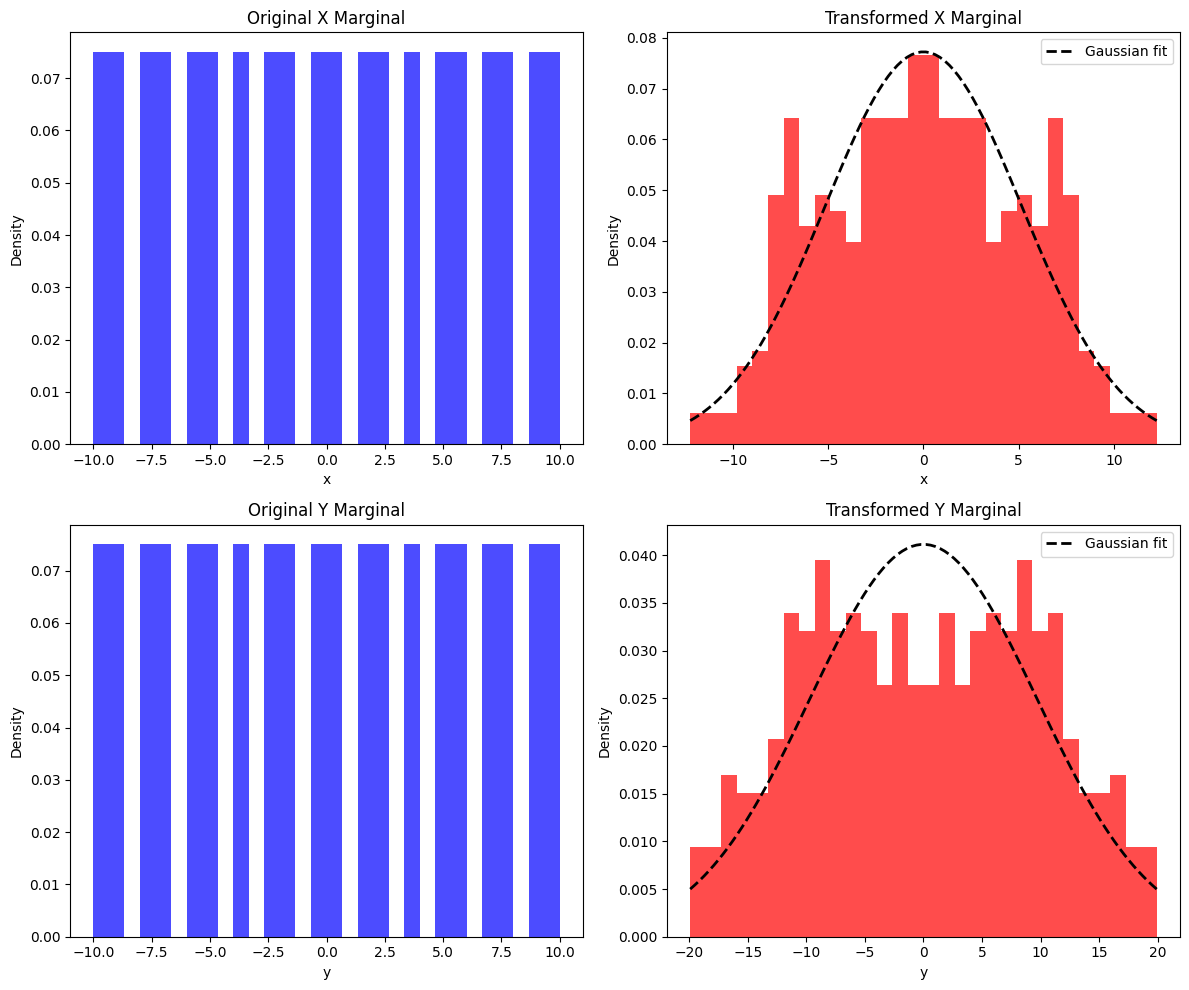

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# X marginal - Original
axes[0, 0].hist(df['x'], bins=30, density=True, alpha=0.7, color='blue')
axes[0, 0].set_xlabel('x')
axes[0, 0].set_ylabel('Density')
axes[0, 0].set_title('Original X Marginal')

# X marginal - Transformed
axes[0, 1].hist(df_transformed['x'], bins=30, density=True, alpha=0.7, color='red')
# Overlay Gaussian fit
x_range = np.linspace(df_transformed['x'].min(), df_transformed['x'].max(), 100)
mu_x = df_transformed['x'].mean()
std_x = df_transformed['x'].std()
gaussian_x = (1/(std_x * np.sqrt(2*np.pi))) * np.exp(-0.5*((x_range - mu_x)/std_x)**2)
axes[0, 1].plot(x_range, gaussian_x, 'k--', linewidth=2, label='Gaussian fit')
axes[0, 1].set_xlabel('x')
axes[0, 1].set_ylabel('Density')
axes[0, 1].set_title('Transformed X Marginal')
axes[0, 1].legend()

# Y marginal - Original
axes[1, 0].hist(df['y'], bins=30, density=True, alpha=0.7, color='blue')
axes[1, 0].set_xlabel('y')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Original Y Marginal')

# Y marginal - Transformed
axes[1, 1].hist(df_transformed['y'], bins=30, density=True, alpha=0.7, color='red')
# Overlay Gaussian fit
y_range = np.linspace(df_transformed['y'].min(), df_transformed['y'].max(), 100)
mu_y = df_transformed['y'].mean()
std_y = df_transformed['y'].std()
gaussian_y = (1/(std_y * np.sqrt(2*np.pi))) * np.exp(-0.5*((y_range - mu_y)/std_y)**2)
axes[1, 1].plot(y_range, gaussian_y, 'k--', linewidth=2, label='Gaussian fit')
axes[1, 1].set_xlabel('y')
axes[1, 1].set_ylabel('Density')
axes[1, 1].set_title('Transformed Y Marginal')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 7. Optimization History

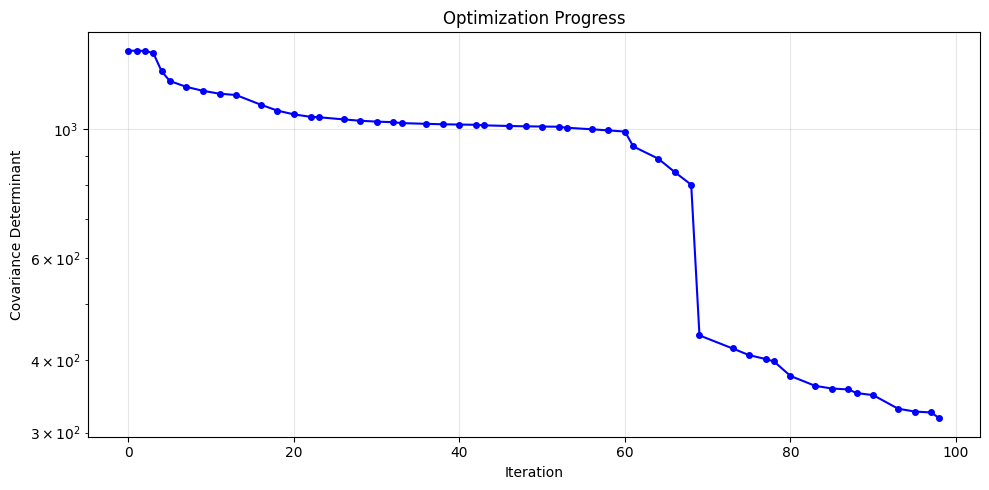

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.semilogy(transformer.history_['iteration'], transformer.history_['determinant'], 'b-o', markersize=4)
ax.set_xlabel('Iteration')
ax.set_ylabel('Covariance Determinant')
ax.set_title('Optimization Progress')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Save Transformed Data to CSV

In [10]:
output_csv = '/tmp/transformed_vectors.csv'
df_transformed.to_csv(output_csv, index=False)
print(f"Saved transformed data to: {output_csv}")
print()
print("First 5 rows:")
df_transformed.head()

Saved transformed data to: /tmp/transformed_vectors.csv

First 5 rows:


,id,x,y,label
0,0,-12.248530,-12.330260,A
1,1,-10.977339,-14.866273,B
2,2,-9.738483,-17.119662,A
3,3,-8.623075,-18.794329,B
4,4,-7.706796,-19.724545,A


## 9. Alternative: One-Liner with transform_csv()

For simple CSV-to-CSV workflows, use the convenience function.

In [ ]:
# Read fresh data from CSV, transform, and save
entropy = transform_csv(
    input_path=input_csv,
    output_path='/tmp/transformed_oneliner.csv',
    columns=['x', 'y'],
    sigma=5.0,
    verbose=True
)

Reading: /tmp/sample_vectors.csv
Fitting transformer: 400 points, 2 dimensions
  sigma = 5.0
  center_stride = 1
  L = 400 basis centers

  Note: H(Gaussian) is the entropy IF the distribution were Gaussian with
  the current covariance. It decreases because we start from uniform.

   Iter     Determinant   H(Gaussian)      Lambda
  --------------------------------------------------
      0    1.364153e+03        6.4470    1.00e+00
      1    1.364041e+03        6.4470    1.00e-01
      2    1.362918e+03        6.4466    1.00e-02
      3    1.351866e+03        6.4425    1.00e-03
      4    1.257528e+03        6.4063    1.00e-04
      5    1.209587e+03        6.3869    1.00e-05
      7    1.181908e+03        6.3753    1.00e-05
      9    1.163433e+03        6.3674    1.00e-05
     11    1.150360e+03        6.3618    1.00e-05
     13    1.141872e+03        6.3581    1.00e-05
     16    1.100783e+03        6.3398    1.00e-04
     18    1.075508e+03        6.3282    1.00e-04
     20    1.0

## 10. Handling Larger Datasets with center_stride

For large datasets, use `center_stride > 1` to reduce the number of basis centers.

In [ ]:
# Generate larger dataset (100x100 = 10000 points)
n_large = 100
x_large = np.linspace(-10, 10, n_large)
y_large = np.linspace(-10, 10, n_large)
xx_large, yy_large = np.meshgrid(x_large, y_large)

df_large = pd.DataFrame({
    'x': xx_large.ravel(),
    'y': yy_large.ravel()
})

print(f"Large dataset: {len(df_large)} points")

In [ ]:
# Use center_stride=10 to use every 10th point as a center
# This reduces 10000 centers to 1000 centers
transformer_large = DataFrameTransformer(
    sigma=5.0,
    center_stride=10,  # Use every 10th point
    max_iterations=50,
    verbose=True
)

df_large_transformed = transformer_large.fit_transform(df_large, columns=['x', 'y'])

In [ ]:
# Visualize large dataset transformation
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].scatter(df_large['x'], df_large['y'], c='blue', alpha=0.3, s=5)
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Original (10000 points)')
axes[0].set_aspect('equal')

axes[1].scatter(df_large_transformed['x'], df_large_transformed['y'], c='red', alpha=0.3, s=5)
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Transformed (center_stride=10)')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()

# Entropy comparison
entropy_large = transformer_large.get_entropy_comparison(df_large, df_large_transformed)
print(f"\nDeterminant reduction: {entropy_large['original']['determinant'] / entropy_large['transformed']['determinant']:.2f}x")

## Summary

Key usage patterns:

```python
# Method 1: DataFrame API
from entra import DataFrameTransformer
transformer = DataFrameTransformer(sigma=5.0)
df_out = transformer.fit_transform(df, columns=['x', 'y', 'z'])

# Method 2: CSV convenience function
from entra import transform_csv
transform_csv('input.csv', 'output.csv', columns=['x', 'y', 'z'])

# For large datasets, use center_stride
transformer = DataFrameTransformer(sigma=5.0, center_stride=10)
```